In [1]:
from src.motion_models.trajectory_generation.route_generation import *
from src.visual.visual_tools import *

import numpy as np

%load_ext autoreload
%autoreload 2

### CV + CA IMM Model

Final state: TrajectoryState(position=array([24.63298531, 35.35168512]), velocity=array([ 2.89139513, 16.87338508]), acceleration=array([-3.52687088,  3.36052273]), omega=None, tau=None)
Final state: TrajectoryState(position=array([ 35.85699968, 102.39669638]), velocity=array([ 2.79077748, 16.92989992]), acceleration=None, omega=None, tau=None)
Generated composite trajectory with 199 total steps
Final state: position=[ 35.85699968 102.39669638], velocity=[ 2.79077748 16.92989992]


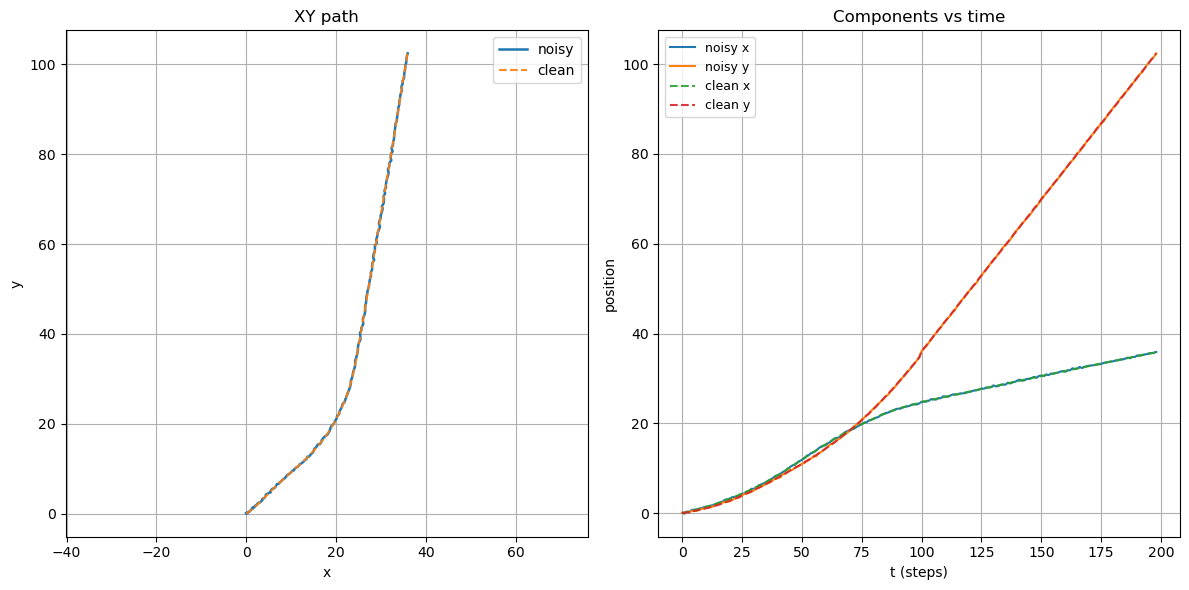

iter 0Model probabilities: [0.50000016 0.49999984]
iter 1Model probabilities: [0.50088781 0.49911219]
iter 2Model probabilities: [0.18069687 0.81930313]
iter 3Model probabilities: [0.95170159 0.04829841]
iter 4Model probabilities: [0.77094522 0.22905478]
iter 5Model probabilities: [0.96489122 0.03510878]
iter 6Model probabilities: [0.99175995 0.00824005]
iter 7Model probabilities: [0.99101927 0.00898073]
iter 8Model probabilities: [0.98486846 0.01513154]
iter 9Model probabilities: [0.98439803 0.01560197]
iter 10Model probabilities: [0.93032007 0.06967993]
iter 11Model probabilities: [0.97695005 0.02304995]
iter 12Model probabilities: [0.97922097 0.02077903]
iter 13Model probabilities: [0.98136023 0.01863977]
iter 14Model probabilities: [0.97462442 0.02537558]
iter 15Model probabilities: [0.97319658 0.02680342]
iter 16Model probabilities: [0.94448668 0.05551332]
iter 17Model probabilities: [0.69440641 0.30559359]
iter 18Model probabilities: [0.03751791 0.96248209]
iter 19Model probabili

In [3]:
from src.motion_models.trajectory_generation.route_generation import TrajectoryState
from src.imm_models.models_for_imm import IMMConstantAccelerationKF, IMMConstantVelocityKF, InitializationData
from filterpy.kalman import IMMEstimator
dt = 0.04

OBSERVATION_NOISE_STD = np.array([0.1, 0.1])
CV_VEL_CHANGE_STD = np.array([0.01, 0.01])
white_accel_density = np.array([10, 10])
accel_noise_std = np.sqrt(dt * white_accel_density)

# Define trajectory segments
segments = [
        ('CA', 100, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([2, 3])}),
    ('CV', 100, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

initial_pos = np.array([0,0])
initial_vel = np.array([3,2])
x0 = np.array([initial_pos[0], initial_vel[0], 0, initial_pos[1], initial_vel[1], 0])
x0= np.zeros((7))
P0 = np.eye(7) * 1e5
initial_state = TrajectoryState(
    position=initial_pos.copy(),
    velocity=initial_vel.copy())
# Generate composite trajectory
noisy, clean, final_state = generate_composite_trajectory(
    trajectory_segments=segments,
    initial_state=initial_state,
    dt=dt,
    dim=2,
    seed=43
)

print(f"Generated composite trajectory with {len(noisy)} total steps")
print(f"Final state: position={final_state.position}, velocity={final_state.velocity}")
P0_cv = P0.copy()
P0_cv[2,2] = 1e-7
P0_cv[5,5] = 1e-7
plot_trajectories_with_predictions_shifted(noisy, clean)
cv1_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=CV_VEL_CHANGE_STD)
cv1_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv1_initial_matrices_data)
cv1_kf.initialize(x0 = x0.copy(), P0=P0_cv.copy())


cv_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, white_accel_density=white_accel_density[0], process_noise_std=accel_noise_std)
ca_kf = IMMConstantAccelerationKF(2, 7, 2, dt, cv_initial_matrices_data)
ca_kf.initialize(x0=x0.copy(), P0=P0.copy())

M=np.array([[0.995,0.005],[0.005,0.995]])
imm = IMMEstimator([cv1_kf, ca_kf], [0.5, 0.5], M = M)

for i,z in enumerate(noisy):
    imm.predict()                   # propagate all models forward
    imm.update(z)                   # update with the new measurement

    #print("Fused state:", imm.x.ravel())
    #print("Fused covariance:", imm.P)
    print(f"iter {i} Model probabilities: {imm.mu}")


### IMM for 2 different CV

Final state: TrajectoryState(position=array([17.60645427, 18.69099212]), velocity=array([-1.09989564,  5.64260997]), acceleration=None, omega=None, tau=None)
Final state: TrajectoryState(position=array([17.30657995, 29.21307953]), velocity=array([ 0.82097385, 10.06458388]), acceleration=None, omega=None, tau=None)
Generated composite trajectory with 179 total steps
Final state: position=[17.30657995 29.21307953], velocity=[ 0.82097385 10.06458388]


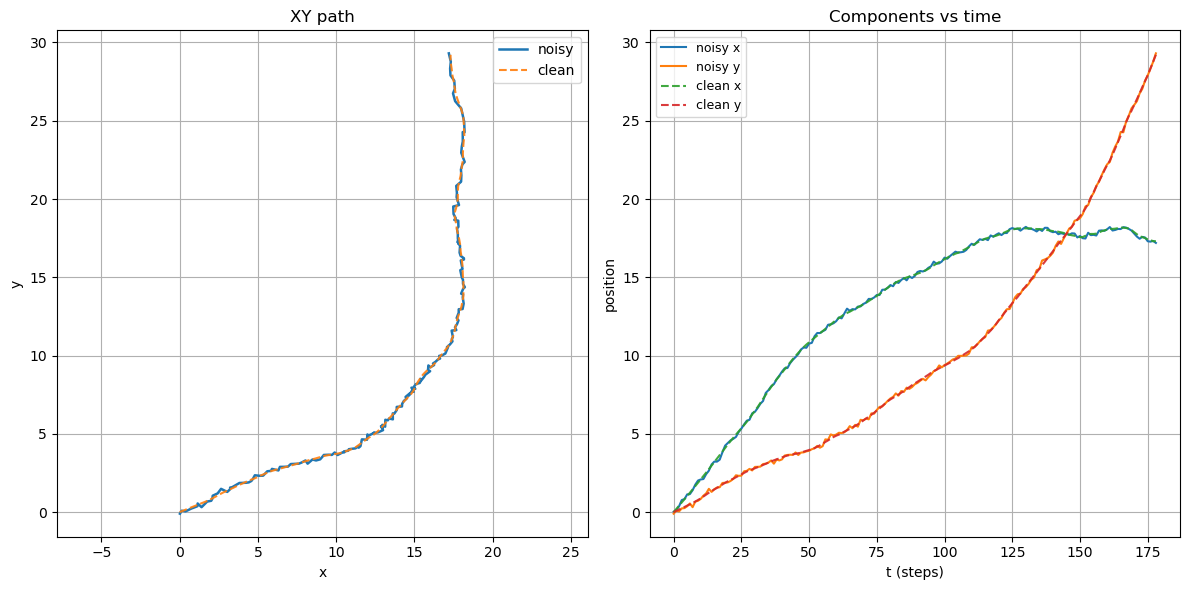

iter 0 Model probabilities: [0.5 0.5]
iter 1 Model probabilities: [0.501565 0.498435]
iter 2 Model probabilities: [0.50407817 0.49592183]
iter 3 Model probabilities: [0.50091075 0.49908925]
iter 4 Model probabilities: [0.53281871 0.46718129]
iter 5 Model probabilities: [0.5674683 0.4325317]
iter 6 Model probabilities: [0.5622468 0.4377532]
iter 7 Model probabilities: [0.53262245 0.46737755]
iter 8 Model probabilities: [0.66282724 0.33717276]
iter 9 Model probabilities: [0.66822464 0.33177536]
iter 10 Model probabilities: [0.72559601 0.27440399]
iter 11 Model probabilities: [0.61711997 0.38288003]
iter 12 Model probabilities: [0.62082121 0.37917879]
iter 13 Model probabilities: [0.49139858 0.50860142]
iter 14 Model probabilities: [0.63964537 0.36035463]
iter 15 Model probabilities: [0.63214997 0.36785003]
iter 16 Model probabilities: [0.71738703 0.28261297]
iter 17 Model probabilities: [0.6336333 0.3663667]
iter 18 Model probabilities: [0.76380808 0.23619192]
iter 19 Model probabilities

In [7]:
from src.motion_models.trajectory_generation.route_generation import TrajectoryState
from src.imm_models.models_for_imm import IMMConstantAccelerationKF, IMMConstantVelocityKF, InitializationData
from filterpy.kalman import IMMEstimator
dt = 0.04

OBSERVATION_NOISE_STD = np.array([0.1, 0.1])
CV_VEL_CHANGE_STD = np.array([0.3, 0.3])
CV2_VEL_CHANGE_STD = np.array([1, 1])

# Define trajectory segments
segments = [
    ('CV', 150, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
    ('CV', 30, {'vel_change_std': CV2_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

initial_pos = np.array([0,0])
initial_vel = np.array([5,2])
x0 = np.array([initial_pos[0], initial_vel[0], 0, initial_pos[1], initial_vel[1], 0])
x0 = np.zeros((7))
P0 = np.eye(7) * 1e2
initial_state = TrajectoryState(
    position=initial_pos.copy(),
    velocity=initial_vel.copy())
# Generate composite trajectory
noisy, clean, final_state = generate_composite_trajectory(
    trajectory_segments=segments,
    initial_state=initial_state,
    dt=dt,
    dim=2,
    seed=43
)

print(f"Generated composite trajectory with {len(noisy)} total steps")
print(f"Final state: position={final_state.position}, velocity={final_state.velocity}")
plot_trajectories_with_predictions_shifted(noisy, clean)
cv1_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=CV_VEL_CHANGE_STD)
cv1_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv1_initial_matrices_data)
cv1_kf.initialize(x0 = x0.copy(), P0=P0.copy())


cv_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=CV2_VEL_CHANGE_STD)
cv2_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv_initial_matrices_data)
cv2_kf.initialize(x0=x0.copy(), P0=P0.copy())

M=np.array([[0.95,0.05],[0.05,0.95]])
imm = IMMEstimator([cv1_kf, cv2_kf], [0.5, 0.5], M = M)

for i,z in enumerate(noisy):
    imm.predict()                   # propagate all models forward
    imm.update(z)                   # update with the new measurement
    print(f"iter {i} Model probabilities: {imm.mu}")



### CA + CT + CV IMM Model

In [11]:
from src.motion_models.trajectory_generation.route_generation import TrajectoryState
from src.imm_models.models_for_imm import IMMConstantAccelerationKF, IMMConstantVelocityKF, IMMCoordinatedTurnKF, InitializationData
from filterpy.kalman import IMMEstimator
dt = 0.04

OBSERVATION_NOISE_STD = np.array([0.1, 0.1])
CV_VEL_CHANGE_STD = np.array([1, 1])
white_accel_density = np.array([0.1, 0.1])
accel_noise_std = np.sqrt(dt * white_accel_density)
OMEGA = 0.7
OMEGA_STD = 0.1
# Define trajectory segments
segments = [
            ('CA', 50, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([2, 3])}),
    ('CT', 150, {'omega': OMEGA, 'measurement_noise_std': OBSERVATION_NOISE_STD[0], 'omega_noise_std': OMEGA_STD}),
        ('CA', 100, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([6, 3])}),
    ('CV', 100, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

"""
segments = [
            ('CA', 50, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([2, 3])}),
    ('CT_NOISE', 150, {'omega': OMEGA, 'measurement_noise_std': OBSERVATION_NOISE_STD[0], 'omega_std': OMEGA_STD,
                       'accel_noise_std': accel_noise_std[0]}),
        ('CA', 40, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([0.1, 0.1])}),
        ('CV', 20, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
        ('CA', 40, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([0.3, 0.3])}),

    ('CV', 100, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

"""

initial_pos = np.array([0,0])
initial_vel = np.array([3,5])
x0 = np.array([initial_pos[0], initial_vel[0], 0, initial_pos[1], initial_vel[1], 0, 0])
#x0= np.zeros((7))
P0 = np.eye(7) * 1e1
initial_state = TrajectoryState(
    position=initial_pos.copy(),
    velocity=initial_vel.copy())
# Generate composite trajectory
noisy, clean, final_state = generate_composite_trajectory(
    trajectory_segments=segments,
    initial_state=initial_state,
    dt=dt,
    dim=2,
    seed=46
)

print(f"Generated composite trajectory with {len(noisy)} total steps")
print(f"Final state: position={final_state.position}, velocity={final_state.velocity}")
cv1_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=CV_VEL_CHANGE_STD)
cv1_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv1_initial_matrices_data)
cv1_kf.initialize(x0 = x0.copy(), P0=P0)


ca_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, white_accel_density=white_accel_density[0], process_noise_std=accel_noise_std)
ca_kf = IMMConstantAccelerationKF(2, 7, 2, dt, ca_initial_matrices_data)
ca_kf.initialize(x0=x0.copy(), P0=P0.copy())

ct_init = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=accel_noise_std, omega_std=OMEGA_STD)
ct_kf = IMMCoordinatedTurnKF(2, 7, 2, dt=dt, initialization_data=ct_init)
ct_kf.initialize(x0=x0.copy(), P0=P0.copy())

M=np.array([[0.98,0.01, 0.01],[0.01,0.98, 0.01], [0.01,0.01, 0.98]])
imm = IMMEstimator([cv1_kf, ca_kf, ct_kf], [0.2, 0.4, 0.2], M = M)

for i,z in enumerate(noisy):              # z is your measurement vector
    imm.predict()                   # propagate all models forward
    imm.update(z)                   # update with the new measurement
    #print("Fused state:", imm.x.ravel())
    #print("Fused covariance:", imm.P)
    print(f"iter {i}Model probabilities: {imm.mu}")



Final state: TrajectoryState(position=array([ 9.51616961, 16.00767014]), velocity=array([ 6.22320282, 11.15108014]), acceleration=array([1.45131549, 3.35001282]), omega=None, tau=None)
Final state: TrajectoryState(position=array([-22.31776438,  17.11219487]), velocity=array([  6.65875148, -10.89659903]), acceleration=None, omega=0.6261903490323802, tau=None)
Final state: TrajectoryState(position=array([55.92727299, -1.70558177]), velocity=array([32.96165357,  2.04873686]), acceleration=array([6.71012242, 3.30532182]), omega=None, tau=None)
Final state: TrajectoryState(position=array([212.64863098,  23.79164524]), velocity=array([43.83478684, 12.90436558]), acceleration=None, omega=None, tau=None)
Generated composite trajectory with 397 total steps
Final state: position=[212.64863098  23.79164524], velocity=[43.83478684 12.90436558]
iter 0Model probabilities: [0.25250083 0.49500132 0.25249785]
iter 1Model probabilities: [0.24905734 0.49412566 0.256817  ]
iter 2Model probabilities: [0.24

Things I learned while experimenting with the IMM:
- Say we have this configuration:
OBSERVATION_NOISE_STD = np.array([0.1, 0.1])
CV_VEL_CHANGE_STD = np.array([0.1, 0.1])
white_accel_density = np.array([0.2, 0.2])
accel_noise_std = np.sqrt(dt * white_accel_density)

It appears that when the acceleration suddenly changes, say from a CT model with 0 acceleration to a CA model with [6,3] acceleration, then because the accel_noise_std is very low, and also the transition covariance was low from the CT motion model (it fit that okay, though worse than the CT KF), then we get that the Kalman Gain is also low, so we don't really "fix" our P - thus making the CA model not respond well to changes. In order to see that, you can run the cell above and see the misclassification. The reason for the misclassification is an hypothesis for now.
However, I did see that when changing the CA model to have a lower acceleration (like the configuration in the commented lines in the cell above), it manages to identify it well. I suppose that's because this difference between no acceleration and 0.1 m/s^2 is small enough for the KF to make the adjustment, even with a small P.
Alternatively, we can make the P bigger by making Q bigger - increasing the accel_noise_std. This works as well, but it also changes the trajectory (because the trajectory of the CA is generated with greater changes in acceleration which most probably change the velocity more quickly)

### k-lag Evaluation With IMM

Final state: TrajectoryState(position=array([ 9.51616961, 16.00767014]), velocity=array([ 6.22320282, 11.15108014]), acceleration=array([1.45131549, 3.35001282]), omega=None, tau=None)
Final state: TrajectoryState(position=array([-22.31776438,  17.11219487]), velocity=array([  6.65875148, -10.89659903]), acceleration=None, omega=0.6261903490323802, tau=None)
Final state: TrajectoryState(position=array([55.92727299, -1.70558177]), velocity=array([32.96165357,  2.04873686]), acceleration=array([6.71012242, 3.30532182]), omega=None, tau=None)
Final state: TrajectoryState(position=array([212.64863098,  23.79164524]), velocity=array([43.83478684, 12.90436558]), acceleration=None, omega=None, tau=None)
Generated composite trajectory with 397 total steps
Final state: position=[212.64863098  23.79164524], velocity=[43.83478684 12.90436558]


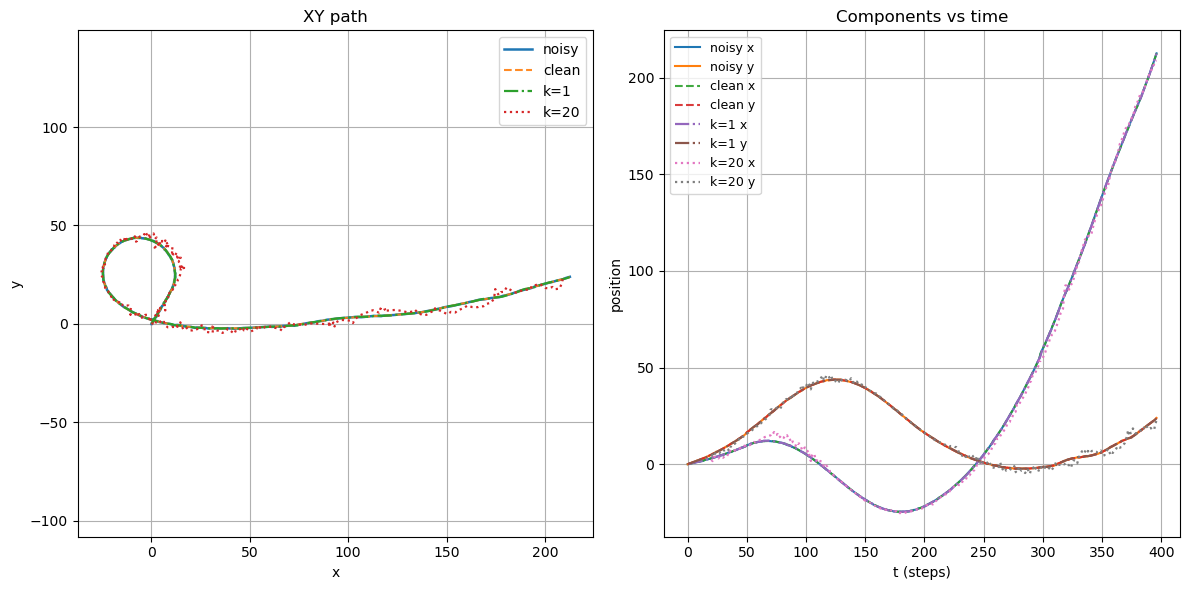

MSE for k=1: 2.0105215015164732e-05
MSE for k=20: 0.0029037660910876365


In [14]:

from src.motion_models.trajectory_generation.route_generation import TrajectoryState
from src.imm_models.models_for_imm import IMMConstantAccelerationKF, IMMConstantVelocityKF, IMMCoordinatedTurnKF, InitializationData
from filterpy.kalman import IMMEstimator
from src.imm_models.imm_k_lag import IMMKlagEvaluator


dt = 0.04
OBSERVATION_NOISE_STD = np.array([0.1, 0.1])
CV_VEL_CHANGE_STD = np.array([1, 1])
white_accel_density = np.array([0.1, 0.1])
accel_noise_std = np.sqrt(dt * white_accel_density)
OMEGA = 0.7
OMEGA_STD = 0.1
# Define trajectory segments
segments = [
    ('CA', 50, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std,
                "acceleration": np.array([2, 3])}),
    ('CT', 150, {'omega': OMEGA, 'measurement_noise_std': OBSERVATION_NOISE_STD[0], 'omega_noise_std': OMEGA_STD}),
    ('CA', 100, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std,
                 "acceleration": np.array([6, 3])}),
    ('CV', 100, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

"""
segments = [
            ('CA', 50, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([2, 3])}),
    ('CT', 150, {'omega': OMEGA, 'measurement_noise_std': OBSERVATION_NOISE_STD[0], 'omega_std': OMEGA_STD,
                       'accel_noise_std': accel_noise_std[0]}),
        ('CA', 40, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([0.1, 0.1])}),
        ('CV', 20, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
        ('CA', 40, {'measurement_noise_std': OBSERVATION_NOISE_STD, 'accel_noise_std': accel_noise_std, "acceleration": np.array([0.3, 0.3])}),

    ('CV', 100, {'vel_change_std': CV_VEL_CHANGE_STD, 'measurement_noise_std': OBSERVATION_NOISE_STD}),
]

"""

initial_pos = np.array([0, 0])
initial_vel = np.array([3, 5])
x0 = np.array([initial_pos[0], initial_vel[0], 0, initial_pos[1], initial_vel[1], 0, 0])
#x0= np.zeros((7))
P0 = np.eye(7) * 1e1
initial_state = TrajectoryState(
    position=initial_pos.copy(),
    velocity=initial_vel.copy())
# Generate composite trajectory
noisy, clean, final_state = generate_composite_trajectory(
    trajectory_segments=segments,
    initial_state=initial_state,
    dt=dt,
    dim=2,
    seed=46
)

print(f"Generated composite trajectory with {len(noisy)} total steps")
print(f"Final state: position={final_state.position}, velocity={final_state.velocity}")
cv1_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD,
                                               process_noise_std=CV_VEL_CHANGE_STD)
cv1_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv1_initial_matrices_data)
cv1_kf.initialize(x0=x0.copy(), P0=P0)

ca_initial_matrices_data = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD,
                                              white_accel_density=white_accel_density[0],
                                              process_noise_std=accel_noise_std)
ca_kf = IMMConstantAccelerationKF(2, 7, 2, dt, ca_initial_matrices_data)
ca_kf.initialize(x0=x0.copy(), P0=P0.copy())

ct_init = InitializationData(observation_noise_std=OBSERVATION_NOISE_STD, process_noise_std=accel_noise_std,
                             omega_std=OMEGA_STD)
ct_kf = IMMCoordinatedTurnKF(2, 7, 2, dt=dt, initialization_data=ct_init)
ct_kf.initialize(x0=x0.copy(), P0=P0.copy())

M = np.array([[0.98, 0.01, 0.01], [0.01, 0.98, 0.01], [0.01, 0.01, 0.98]])
imm = IMMEstimator([cv1_kf, ca_kf, ct_kf], [0.2, 0.4, 0.2], M=M)


ev = IMMKlagEvaluator(imm)
mse, preds = ev.run_k_lag(noisy, k=1, clean_signal=clean, normalize_mse=True)

#Need to restart the IMM because its internal state is now changed due to the previous run. This includes initializing the IMM and all the KFs
cv1_kf.initialize(x0=x0.copy(), P0=P0)
ca_kf.initialize(x0=x0.copy(), P0=P0)
ct_kf.initialize(x0=x0.copy(), P0=P0)
imm = IMMEstimator([cv1_kf, ca_kf, ct_kf], [0.2, 0.4, 0.2], M=M)
ev = IMMKlagEvaluator(imm)

k_lag = 20
mse_large_k, preds_large_k = ev.run_k_lag(noisy, k=k_lag, clean_signal=clean, normalize_mse=True)
plot_trajectories_with_predictions_shifted(noisy, clean, [(preds, 1), (preds_large_k, k_lag)])
print(f"MSE for k=1: {mse}")
print(f"MSE for k={k_lag}: {mse_large_k}")
